This is a **Colab** implementation of the code for **SS_and_expression_systems** project

The code consists of several parts:

1.   **Data preprocessing** - we use [PDB's ss.txt file](https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz) to create a csv file with AA and SS sequences in a table format for all available entries
2.   **BLASTp and filtering** - we load the results of BLASTp ran in DAMBE and filter them
3.   **Data files creation** - we use filtered BLASTp results to create a separate data file for each protein database. Each Protein origin species / Expression system pair has a separate database
4.   **Matrix creation** - for each data file we create a count matrix with AA /SS pairs
5.   **Matrix comparison** - matrices are compared visually and KL distances are calculated between them
6.   **Data file splitting** - this is done to remove protein length and number of proteins factors. Full data files are split into parts of equal lenghs and each segment is compared to the same segment in the other data file
7.   **Statistical analysis of splited files** - we compare KL distances between segments of different data files. We obtain median KL distances to  compare effect of having *E. coli* as an expression system for proteins from different source organisms

# Libraries

In [1]:
!pip install scikit_posthocs
!pip install pingouin

     |████████████████████████████████| 51kB 2.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-cp37-none-any.whl size=37886 sha256=c189a96e073b20fe8b07d057060200bd1389df37115cf683864f73c15ed1d64b
  Stored in directory: /root/.cache/pip/wheels/00/0f/56/897c22820a48a74f50f1a85faaa4b133bb8865e8b094b596f5
Successfully built scikit-posthocs
     |████████████████████████████████| 204kB 5.1MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.11-cp37-none-any.whl size=203325 sha256=c737dd41d8c2c0261d82730d786e7b8f42e02d4321e1564bbd626e5d057ee40e
  Stored in directory: /root/.cache/pip/wheels/79/46/ef/e377eb45c86f278f660d31c4a30e3f733063d28c89462f1aea
  Created wheel for littleutils: filename=littleutils-0.2.2-cp37-none-any.whl size=7051 sha256=38596ca3daa717b3e59a718a188363250f92de8809bce0c50008324d532fe8b0
  Stored in directory: /root/.

In [2]:
# essential ones:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# files handling in Colab:
from google.colab import files
from io import StringIO

# loop iteration visualization:
from tqdm import tqdm

# statistical analysis
from scikit_posthocs import posthoc_dunn, posthoc_mannwhitney
from scipy import stats
from pingouin import pairwise_ttests

import matplotlib.colors

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data preprocessing

We use [PDB's ss.txt file](https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz) to create a csv file with AA and SS sequences in a table format for all available entries

The table would be more eficient for later tasks than the original file

In this file coil SS are repreneted by spaces, " ", we need to replace the spaces with "C"

## Load the ss.txt file

In [ ]:
uploaded = files.upload()

Saving SS_data_processed.csv to SS_data_processed.csv


In [ ]:
d_lines = uploaded['ss.txt'].decode('utf-8').split('\n')

## Separate lines in 3 lists:

1.   **seq_names** - sequence names list
2.   **AA_seqs** - AA sequences list
3.   **SS_seqs** - SS sequences list


This is tricky because sequences can occupy various number of lines. We will need to utilize the **'>'** characters to distinguish between sequence names and sequences. For each sequence, we will concatenate each line until the next **'>'** character. We will also have to iterate a variable **seq_type** to separate AA from SS

In [ ]:
seq_names = []
AA_seqs = []
SS_seqs = []
seq_type = 'AA'
seq = ''        # we will concatenate sequences to this string

for line in d_lines[:-1]:                      # last line is empty, so we do not include it
  if line[0] == '>':                               # indicates sequence name
    if seq_type == 'AA':
      if seq != '':
        AA_seqs.append(seq)
        seq_type = 'SS'
        seq = ''
      seq_names.append(line[1:7])
    elif seq_type == 'SS':
      if seq != '':
        SS_seqs.append(seq.replace(' ','C'))
        seq_type = 'AA'
        seq = ''
      continue
  else:                                            # indicates sequence string
    seq += line
SS_seqs.append(seq.replace(' ','C'))               # append the last line

## Create a dataframe and save as CSV

In [ ]:
d_processed = pd.DataFrame({'AA_seq':AA_seqs, 'SS_seq':SS_seqs}, index=seq_names[1:])

In [ ]:
d_processed.to_csv('SS_data_processed.csv')
files.download('SS_data_processed.csv')

NameError: ignored

Or load the file from disk

In [ ]:
uploaded = files.upload()

Saving SS_data_processed.csv to SS_data_processed.csv


In [ ]:
d_processed = pd.read_csv('SS_data_processed.csv')
d_processed.index = d_processed['Unnamed: 0']

# BLASTp filtering

We use BLASTp results obtained in DAMBE. The results were saved as CSV files. We will filter the results to get PDB entries with same (or almost identical) AA sequences and different Expression systems

In [ ]:
uploaded = files.upload()

Saving 05_Bsubtilis_BLAST_results_filtered.csv to 05_Bsubtilis_BLAST_results_filtered.csv
Saving 05_Dvulgaris_BLAST_results_filtered.csv to 05_Dvulgaris_BLAST_results_filtered.csv
Saving 05_Llactis_BLAST_results_filtered.csv to 05_Llactis_BLAST_results_filtered.csv
Saving 05_Pfluorescens_BLAST_results_filtered.csv to 05_Pfluorescens_BLAST_results_filtered.csv
Saving 05_Pputida_BLAST_results_filtered.csv to 05_Pputida_BLAST_results_filtered.csv
Saving 05_Senterica_BLAST_results_filtered.csv to 05_Senterica_BLAST_results_filtered.csv
Saving 05_Srubiginosus_BLAST_results_filtered.csv to 05_Srubiginosus_BLAST_results_filtered.csv
Saving 05_Tthermophilus_BLAST_results_filtered.csv to 05_Tthermophilus_BLAST_results_filtered.csv


In [ ]:
def filter_BLASTp(filename, download=False, min_match=95, min_len=50, max_e=0.01):
  '''
  BLASTp filtering, creation of a dataframe and optional saving of a CSV
  '''
  BLAST_results = pd.read_csv(StringIO(str(uploaded[filename],'utf-8')))
  BLAST_results_filtered = BLAST_results[(BLAST_results['%Match'] >= min_match) &
                                         (BLAST_results['MatchLen'] >= min_len) &
                                         (BLAST_results['E-Val'] <= max_e)]
  BLAST_results_filtered = BLAST_results_filtered.reset_index().iloc[:,1:]
  if download == True:
    newname = filename.replace('04', '05').replace('.csv', '_results_filtered.csv')
    BLAST_results_filtered.to_csv(newname)
    files.download(newname)
  return BLAST_results_filtered

**filtered_BLASTps** dictionary will have all filtered BLASTp results stored as dataframes. The dataframes can also be downloaded as CSV files using the *'download=True'* option

In [ ]:
filtered_BLASTps = {}
db_names = ['BS', 'DV', 'LL', 'PF', 'PP', 'SE', 'SR', 'TT']
for filename, db_name in zip(uploaded.keys(), db_names):
  filtered_BLASTps[db_name] = filter_BLASTp(filename, download=False)

NameError: ignored

# Data files creation

The entries names in BLASTp file need to be connected with the AA and SS sequences in the ss.txt file (which has been preprocessed into a dataframe).

A single Query entry can have multiple DB entries, separated by '_' symbol. Not only the DB entries need to be separated from each other, but the Query entries need to be multiplied so that each DB entry has a Query entry pair. The function below will tackle this issue

In [ ]:
def create_data_file(filtered_BLASTp_file, db_name, q_name='Ecoli', download=False):
  '''
  Create a data file from the filtered BLASTp dataframe. Data files will have AA and SS sequences for all PDB entries in the BLASTp file in FASTA format

  Query and Database names need to be specified

  Optionally, the result file will be downloaded to the local disk
  '''
  # create lists
  DB_list = [filtered_BLASTp_file.loc[i,'DB_Seq'].split('_') for i in range(len(filtered_BLASTp_file))]    # list of DB sequences separated from each other
  multiplier_list = [filtered_BLASTp_file.loc[i,'DB_Seq'].count('_') + 1 for i in range(len(filtered_BLASTp_file))]    # list of integers to multiply Query entries
  Q_list = list(filtered_BLASTp_file['Query'])    # list of Query entries
  QS_list = list(filtered_BLASTp_file['QueryStart'].astype(int))    # list of Query start positions
  QE_list = list(filtered_BLASTp_file['QueryEnd'].astype(int))    # list of Query end positions
  DBS_list = list(filtered_BLASTp_file['DB_SeqStart'].astype(int))    # list of DB start positions
  DBE_list = list(filtered_BLASTp_file['DB_SeqEnd'].astype(int))    # list of DB end positions

  # create lines for Query entries
  Q_AA_line = ''
  Q_SS_line = ''
  for Q, QS, QE, mult in zip(Q_list, QS_list, QE_list, multiplier_list):
    AA_seq = d_processed.loc[Q]['AA_seq'][QS-1:QE]
    SS_seq = d_processed.loc[Q]['SS_seq'][QS-1:QE]
    Q_AA_line += ('*' + AA_seq) * mult
    Q_SS_line += ('*' + SS_seq) * mult

  # create lines for DB entries
  DB_AA_line = ''
  DB_SS_line = ''
  for DB, DBS, DBE in zip(DB_list, DBS_list, DBE_list):
    AA_line = ''
    SS_line = ''
    for DB_i in DB:
      AA_seq = d_processed.loc[DB_i]['AA_seq'][DBS-1:DBE]
      SS_seq = d_processed.loc[DB_i]['SS_seq'][DBS-1:DBE]
      AA_line += ('*' + AA_seq)
      SS_line += ('*' + SS_seq)
    DB_AA_line += AA_line
    DB_SS_line += SS_line

  # make data files with option to save in FASTA format
  datafiles = {}
  Q_data_file_name = '06_' + db_name + '_' + q_name + '_datafile.fas'
  DB_data_file_name = '06_' + db_name + '_' + db_name + '_datafile.fas'
  for n, aa, ss in zip([Q_data_file_name, DB_data_file_name],
                       [Q_AA_line, DB_AA_line],
                       [Q_SS_line, DB_SS_line]):
    datafiles[n] = open(n, 'w')
    datafiles[n].write('>AA\n')
    datafiles[n].write(aa + '\n')
    datafiles[n].write('>SS\n')
    datafiles[n].write(ss)
    datafiles[n].close()
    if download == True:
      files.download(n)

  return datafiles

In [ ]:
datafiles = {}
species_names = ['Bsubtilis', 'Dvulgaris', 'Llactis', 'Pfluorescens', 'Pputida', 'Senterica', 'Srubiginosus', 'Tthermophilus']
for BLASTp, species_name in zip(filtered_BLASTps.keys(), species_names):
  print(species_name)
  datafiles[species_name] = create_data_file(filtered_BLASTps[BLASTp], species_name, q_name='Ecoli', download=False)

Bsubtilis
Dvulgaris
Llactis
Pfluorescens
Pputida
Senterica
Srubiginosus
Tthermophilus


In [ ]:
#create_data_file(filtered_BLASTps['TT'], 'Tthermophilus', 'Ecoli', True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'06_Tthermophilus_Ecoli_datafile.fas': <_io.TextIOWrapper name='06_Tthermophilus_Ecoli_datafile.fas' mode='w' encoding='UTF-8'>,
 '06_Tthermophilus_Tthermophilus_datafile.fas': <_io.TextIOWrapper name='06_Tthermophilus_Tthermophilus_datafile.fas' mode='w' encoding='UTF-8'>}

Option to upload data files to avoid previous steps:

In [ ]:
uploaded = files.upload()

datafiles = {}
species_names = ['Bsubtilis', 'Dvulgaris', 'Llactis', 'Pfluorescens', 'Pputida', 'Senterica', 'Srubiginosus', 'Tthermophilus']
f = 0
for i, species_name in enumerate(species_names):
  d = {}
  while f <= i*2:
    d[list(uploaded.keys())[f]] = uploaded[list(uploaded.keys())[f]].decode('utf-8').split('\n')
    d[list(uploaded.keys())[f+1]] = uploaded[list(uploaded.keys())[f+1]].decode('utf-8').split('\n')
    f += 2
  datafiles[species_name] = d

Saving 06_Bsubtilis_Bsubtilis_datafile.fas to 06_Bsubtilis_Bsubtilis_datafile (1).fas
Saving 06_Bsubtilis_Ecoli_datafile.fas to 06_Bsubtilis_Ecoli_datafile (1).fas
Saving 06_Dvulgaris_Dvulgaris_datafile.fas to 06_Dvulgaris_Dvulgaris_datafile (1).fas
Saving 06_Dvulgaris_Ecoli_datafile.fas to 06_Dvulgaris_Ecoli_datafile (1).fas
Saving 06_Llactis_Ecoli_datafile.fas to 06_Llactis_Ecoli_datafile (1).fas
Saving 06_Llactis_Llactis_datafile.fas to 06_Llactis_Llactis_datafile (1).fas
Saving 06_Pfluorescens_Ecoli_datafile.fas to 06_Pfluorescens_Ecoli_datafile (1).fas
Saving 06_Pfluorescens_Pfluorescens_datafile.fas to 06_Pfluorescens_Pfluorescens_datafile (1).fas
Saving 06_Pputida_Ecoli_datafile.fas to 06_Pputida_Ecoli_datafile (1).fas
Saving 06_Pputida_Pputida_datafile.fas to 06_Pputida_Pputida_datafile (1).fas
Saving 06_Senterica_Ecoli_datafile.fas to 06_Senterica_Ecoli_datafile (1).fas
Saving 06_Senterica_Senterica_datafile.fas to 06_Senterica_Senterica_datafile (1).fas
Saving 06_Srubiginosus

# Count matrix creation

No we have data files for every species with "native" and *E. coli* expression systems. We will create count matrices for each data file for later comparison. THe count matrices will show how often each AA corresponds to each SS in the data file

The count matrices will have fixed levels, because some rare AA and SS might not be in all data files

In [ ]:
def get_counts(datafile, download=False, pseudocounts=0):
  AA_types = ['*','A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','X','Y']
  SS8_types = ['*','B','C','E','G','H','I','S','T']

  with open(datafile, 'r') as f:
    lines = f.readlines()
    AA_line = lines[1]
    SS_line = lines[3]

  count_matrix_8 = pd.DataFrame(np.full((len(SS8_types), len(AA_types)), fill_value=pseudocounts), columns=AA_types, index=SS8_types)
  for i in tqdm(range(len(AA_line)-1), desc='Count Matrix calculation for %s' %datafile):
    count_matrix_8.loc[SS_line[i], AA_line[i]] += 1
  
  if download == True:
    newname = datafile.replace('06', '07').replace('datafile.fas', 'CM_overall.csv')
    count_matrix_8.to_csv(newname)
    files.download(newname)
  return count_matrix_8

In [ ]:
count_matrices = {}
species_names = ['Bsubtilis', 'Dvulgaris', 'Llactis', 'Pfluorescens', 'Pputida', 'Senterica', 'Srubiginosus', 'Tthermophilus']
for species_name in species_names:
  for datafile_name in datafiles[species_name].keys():
    matrix_name = datafile_name.replace('06', '07').replace('datafile.fas', 'CM_overall.csv')
    count_matrices[matrix_name] = get_counts(datafile_name, download=True, pseudocounts=1e-10)

Count Matrix calculation for 06_Bsubtilis_Bsubtilis_datafile.fas: 100%|██████████| 8997/8997 [00:01<00:00, 4696.82it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Bsubtilis_Ecoli_datafile.fas: 100%|██████████| 8997/8997 [00:01<00:00, 4636.15it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Dvulgaris_Dvulgaris_datafile.fas: 100%|██████████| 11799/11799 [00:02<00:00, 4731.84it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Dvulgaris_Ecoli_datafile.fas: 100%|██████████| 11799/11799 [00:02<00:00, 4899.62it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Llactis_Ecoli_datafile.fas: 100%|██████████| 2380/2380 [00:00<00:00, 4913.60it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Llactis_Llactis_datafile.fas: 100%|██████████| 2380/2380 [00:00<00:00, 4830.43it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Pfluorescens_Ecoli_datafile.fas: 100%|██████████| 4312/4312 [00:00<00:00, 4441.33it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Pfluorescens_Pfluorescens_datafile.fas: 100%|██████████| 4312/4312 [00:00<00:00, 4663.86it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Pputida_Ecoli_datafile.fas: 100%|██████████| 19542/19542 [00:03<00:00, 5194.88it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Pputida_Pputida_datafile.fas: 100%|██████████| 19542/19542 [00:03<00:00, 4997.63it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Senterica_Ecoli_datafile.fas: 100%|██████████| 60471/60471 [00:12<00:00, 4823.36it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Senterica_Senterica_datafile.fas: 100%|██████████| 60471/60471 [00:12<00:00, 4896.16it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Srubiginosus_Ecoli_datafile.fas: 100%|██████████| 72642/72642 [00:14<00:00, 4902.97it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Srubiginosus_Srubiginosus_datafile.fas: 100%|██████████| 72642/72642 [00:14<00:00, 4962.74it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Tthermophilus_Ecoli_datafile.fas: 100%|██████████| 1779/1779 [00:00<00:00, 4063.09it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Count Matrix calculation for 06_Tthermophilus_Tthermophilus_datafile.fas: 100%|██████████| 1779/1779 [00:00<00:00, 5453.40it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
get_counts('06_Senterica_Ecoli_datafile.fas', download=True, pseudocounts=1e-10)

Count Matrix calculation for 06_Senterica_Ecoli_datafile.fas: 100%|██████████| 60471/60471 [00:14<00:00, 4242.94it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,*,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,X,Y
*,1.670000e+02,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10
B,1.000000e-10,5.000000e+00,1.560000e+02,1.000000e-10,1.560000e+02,1.000000e-10,1.800000e+01,3.160000e+02,1.000000e-10,1.000000e-10,3.120000e+02,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e+00,2.000000e+00,9.000000e+00,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e+00
C,1.000000e-10,1.288000e+03,1.800000e+01,8.710000e+02,3.370000e+02,1.870000e+02,1.445000e+03,2.050000e+02,8.330000e+02,5.800000e+01,8.810000e+02,1.103000e+03,7.600000e+02,2.051000e+03,5.020000e+02,3.580000e+02,7.090000e+02,5.100000e+02,8.390000e+02,9.000000e+00,1.000000e-10,1.100000e+01
E,1.000000e-10,4.490000e+02,1.830000e+02,1.870000e+02,2.940000e+02,2.110000e+02,4.920000e+02,1.660000e+02,4.080000e+02,3.240000e+02,8.540000e+02,2.210000e+02,1.750000e+02,2.100000e+01,9.000000e+00,6.800000e+01,3.900000e+01,1.990000e+02,1.652000e+03,2.000000e+00,1.000000e-10,2.000000e+01
G,1.000000e-10,5.170000e+02,1.000000e-10,1.560000e+02,2.190000e+02,1.000000e+00,2.970000e+02,1.000000e+00,1.000000e-10,5.600000e+01,2.660000e+02,1.000000e+00,8.000000e+00,5.750000e+02,9.400000e+01,3.750000e+02,2.370000e+02,1.900000e+01,3.310000e+02,1.560000e+02,1.000000e-10,1.580000e+02
H,1.000000e-10,5.793000e+03,6.400000e+02,1.005000e+03,1.069000e+03,6.650000e+02,1.122000e+03,6.350000e+02,1.502000e+03,5.100000e+02,3.213000e+03,1.167000e+03,6.750000e+02,3.580000e+02,1.229000e+03,1.690000e+03,1.032000e+03,1.315000e+03,2.528000e+03,3.000000e+01,1.000000e-10,3.320000e+02
I,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10
S,1.000000e-10,6.500000e+02,1.000000e-10,1.760000e+02,3.590000e+02,2.100000e+01,7.230000e+02,4.000000e+00,1.100000e+01,1.430000e+02,2.280000e+02,2.020000e+02,1.300000e+01,8.100000e+01,1.200000e+01,1.600000e+02,1.330000e+02,3.380000e+02,3.050000e+02,9.000000e+00,1.000000e-10,2.100000e+02
T,1.000000e-10,6.220000e+02,1.590000e+02,2.130000e+02,9.500000e+01,2.900000e+01,2.235000e+03,1.400000e+01,2.870000e+02,3.410000e+02,3.700000e+02,1.570000e+02,5.470000e+02,5.310000e+02,6.700000e+01,3.400000e+02,3.470000e+02,2.500000e+01,2.380000e+02,1.000000e-10,1.000000e-10,7.000000e+00


Option to load the count matrices to avoid previous steps:

In [ ]:
uploaded = files.upload()

count_matrices = {}
for matrix_name in uploaded.keys():
  count_matrices[matrix_name] = pd.read_csv(StringIO(str(uploaded[matrix_name],'utf-8')), index_col='Unnamed: 0')

Saving 07_Bsubtilis_Bsubtilis_CM_overall.csv to 07_Bsubtilis_Bsubtilis_CM_overall.csv
Saving 07_Bsubtilis_Ecoli_CM_overall.csv to 07_Bsubtilis_Ecoli_CM_overall.csv
Saving 07_Dvulgaris_Dvulgaris_CM_overall.csv to 07_Dvulgaris_Dvulgaris_CM_overall.csv
Saving 07_Dvulgaris_Ecoli_CM_overall.csv to 07_Dvulgaris_Ecoli_CM_overall.csv
Saving 07_Llactis_Ecoli_CM_overall.csv to 07_Llactis_Ecoli_CM_overall.csv
Saving 07_Llactis_Llactis_CM_overall.csv to 07_Llactis_Llactis_CM_overall.csv
Saving 07_Pfluorescens_Ecoli_CM_overall.csv to 07_Pfluorescens_Ecoli_CM_overall.csv
Saving 07_Pfluorescens_Pfluorescens_CM_overall.csv to 07_Pfluorescens_Pfluorescens_CM_overall.csv
Saving 07_Pputida_Ecoli_CM_overall.csv to 07_Pputida_Ecoli_CM_overall.csv
Saving 07_Pputida_Pputida_CM_overall.csv to 07_Pputida_Pputida_CM_overall.csv
Saving 07_Senterica_Ecoli_CM_overall.csv to 07_Senterica_Ecoli_CM_overall.csv
Saving 07_Senterica_Senterica_CM_overall.csv to 07_Senterica_Senterica_CM_overall.csv
Saving 07_Srubiginosus

We will create functions:

*   to create an SS3 matrix from the original SS8 matrix
*   to get proportions out of counts



In [ ]:
def change_to_SS3(SS8_matrix):
  AA_types = ['*','A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','X','Y']
  SS3_types = ['*', 'C', 'E', 'H']

  SS3_matrix = pd.DataFrame(np.zeros((len(SS3_types), len(AA_types))), columns=AA_types, index=SS3_types)
  for AA in AA_types:
    SS3_matrix.loc['*', AA] = SS8_matrix.loc['*', AA]
    SS3_matrix.loc['C', AA] = sum(SS8_matrix.loc[['C', 'S', 'T'], AA])
    SS3_matrix.loc['E', AA] = sum(SS8_matrix.loc[['E', 'B'], AA])
    SS3_matrix.loc['H', AA] = sum(SS8_matrix.loc[['H', 'G', 'I'], AA])
  return SS3_matrix

In [ ]:
def get_proportions(count_matrix):
  prop_matrix = count_matrix.copy()
  matrix_sum = count_matrix.values.sum()
  for i in range(len(count_matrix.index)):
    for j in range(len(count_matrix.columns)):
      prop_matrix.iloc[i,j] = count_matrix.iloc[i,j] / matrix_sum
  return prop_matrix

# Matrix comparison

We will calculate [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) for each Protein origin species between matrices with "native" and *E. coli* Expression systems

In [ ]:
def calculate_KLd(matrix_native, matrix_EC, SS_types=8, graph=False, title='', download=False):
  # transform to 3 SS types if needed:
  if SS_types == 3:
    matrix_native = change_to_SS3(matrix_native)
    matrix_EC = change_to_SS3(matrix_EC)
  
  # get proportions from counts
  m_1 = get_proportions(matrix_native)
  m_2 = get_proportions(matrix_EC)

  # transform into vectors
  m_1 = np.concatenate(m_1.values)
  m_2 = np.concatenate(m_2.values)
  
  # calculation
  kld = m_1 * np.log(m_1 / m_2)

  # graph
  if graph==True:
    subtitle = 'KL div. = ' + str(round(np.sum(kld), 5))
    D_matrix = kld.reshape((matrix_native.shape))
    if SS_types == 8:
        fig_size = (7, 4)
        grid_kws = {'height_ratios': (0.9, .05), 'hspace': .3}
    elif SS_types == 3:
        fig_size = (7, 3)
        grid_kws = {'height_ratios': (0.9, .05), 'hspace': .005}
    f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize = fig_size)
    ax.set_title(title, va = 'top' , style='italic')
    ax.text(0,0, subtitle)
    sns.heatmap(D_matrix, linewidth=0.5, center = 0, cmap=sns.diverging_palette(10, 200, sep=50, as_cmap=True),
                vmax = 0.008, vmin = -0.008, xticklabels=matrix_native.columns, yticklabels=matrix_native.index,
                square = True, ax=ax, cbar_ax=cbar_ax, cbar_kws={'orientation': 'horizontal'})
    if download == True:
      plt.savefig('10_' + title.replace('. ','') + '_KL_divergence_' + str(SS_types) + '.png')
      files.download('10_' + title.replace('. ','') + '_KL_divergence_' + str(SS_types) + '.png')

  return np.sum(kld)

In [ ]:
print('KL divergence:', '\t', 'SS3', '\t\t', 'SS8')
for species in species_names:
  m_1 = change_to_SS3(count_matrices['07_%s_%s_CM_overall.csv' %(species, species)])
  m_2 = change_to_SS3(count_matrices['07_%s_Ecoli_CM_overall.csv' %species])
  kld3 = calculate_KLd(m_1, m_2)
  m_1 = count_matrices['07_%s_%s_CM_overall.csv' %(species, species)]
  m_2 = count_matrices['07_%s_Ecoli_CM_overall.csv' %species]
  kld8 = calculate_KLd(m_1, m_2)
  print(species, '\t', round(kld3, 5), '\t', round(kld8, 5))

KL divergence: 	 SS3 		 SS8
Bsubtilis 	 0.00512 	 0.03001
Dvulgaris 	 0.00762 	 0.02056
Llactis 	 0.02463 	 0.05394
Pfluorescens 	 0.00594 	 0.05205
Pputida 	 0.00066 	 0.00446
Senterica 	 0.00097 	 0.00734
Srubiginosus 	 0.00172 	 0.02201
Tthermophilus 	 0.04023 	 0.44067


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

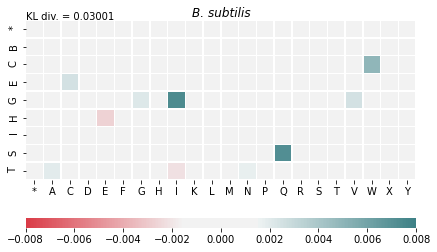

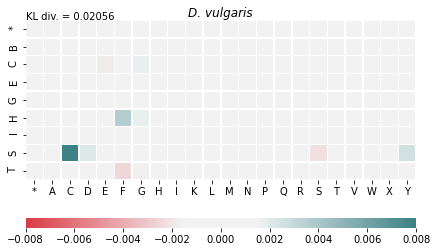

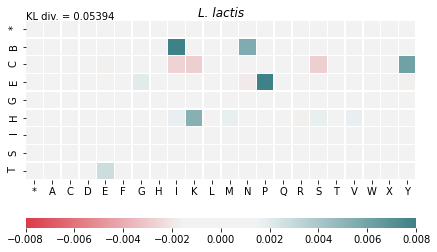

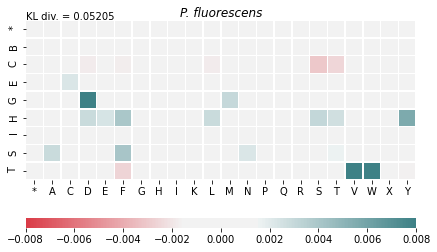

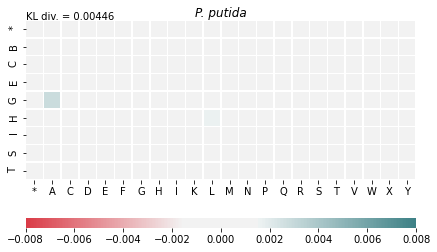

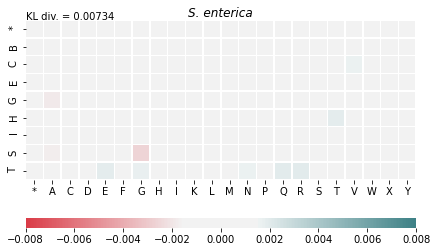

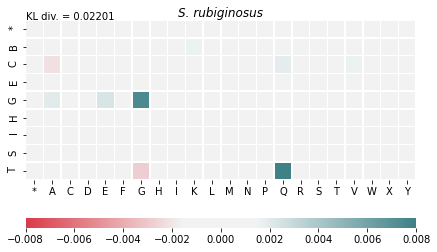

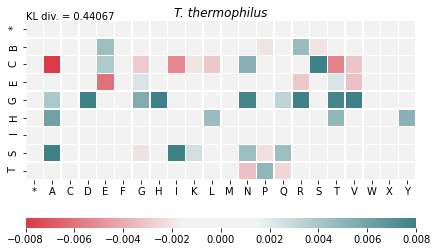

In [ ]:
for species in species_names:
  calculate_KLd(count_matrices['07_%s_%s_CM_overall.csv' %(species, species)],
                count_matrices['07_%s_Ecoli_CM_overall.csv' %species], SS_types=8,
                graph=True, title=(species[0] + '. ' + species[1:]), download=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

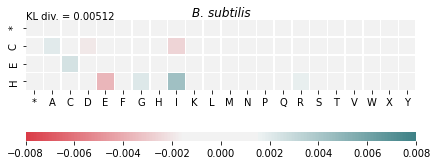

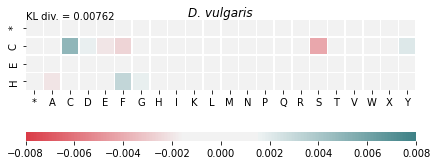

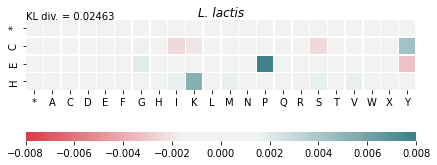

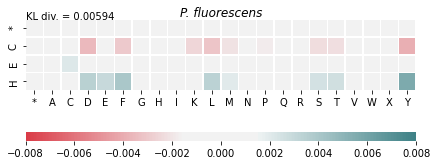

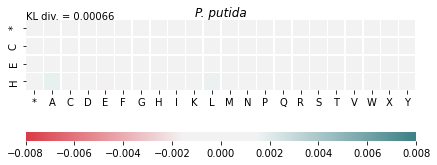

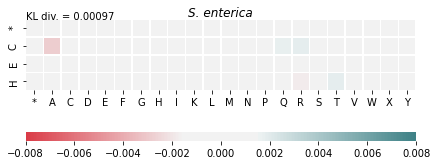

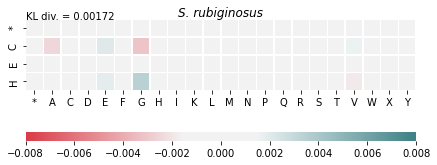

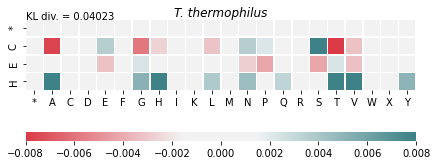

In [ ]:
for species in species_names:
  calculate_KLd(count_matrices['07_%s_%s_CM_overall.csv' %(species, species)],
                count_matrices['07_%s_Ecoli_CM_overall.csv' %species], SS_types=3,
                graph=True, title=(species[0] + '. ' + species[1:]), download=True)

# Splitting data files

KL divergence we calculated previously is for entire data files. We want to see if that is consistent across the data files rather than just some parts of them. We will split the data files into equal sets of 100 residues and calculate KL divergence for those splits. We will than compare the KL divergence values across different Protein source species 

## Import data files

In [ ]:
uploaded = files.upload()

datafiles = {}
species_names = ['Bsubtilis', 'Dvulgaris', 'Llactis', 'Pfluorescens', 'Pputida', 'Senterica', 'Srubiginosus', 'Tthermophilus']
f = 0
for i, species_name in enumerate(species_names):
  d = {}
  while f <= i*2:
    d[list(uploaded.keys())[f]] = uploaded[list(uploaded.keys())[f]].decode('utf-8').split('\n')
    d[list(uploaded.keys())[f+1]] = uploaded[list(uploaded.keys())[f+1]].decode('utf-8').split('\n')
    f += 2
  datafiles[species_name] = d

Saving 06_Bsubtilis_Bsubtilis_datafile.fas to 06_Bsubtilis_Bsubtilis_datafile.fas
Saving 06_Bsubtilis_Ecoli_datafile.fas to 06_Bsubtilis_Ecoli_datafile.fas
Saving 06_Dvulgaris_Dvulgaris_datafile.fas to 06_Dvulgaris_Dvulgaris_datafile.fas
Saving 06_Dvulgaris_Ecoli_datafile.fas to 06_Dvulgaris_Ecoli_datafile.fas
Saving 06_Llactis_Ecoli_datafile.fas to 06_Llactis_Ecoli_datafile.fas
Saving 06_Llactis_Llactis_datafile.fas to 06_Llactis_Llactis_datafile.fas
Saving 06_Pfluorescens_Ecoli_datafile.fas to 06_Pfluorescens_Ecoli_datafile.fas
Saving 06_Pfluorescens_Pfluorescens_datafile.fas to 06_Pfluorescens_Pfluorescens_datafile.fas
Saving 06_Pputida_Ecoli_datafile.fas to 06_Pputida_Ecoli_datafile.fas
Saving 06_Pputida_Pputida_datafile.fas to 06_Pputida_Pputida_datafile.fas
Saving 06_Senterica_Ecoli_datafile.fas to 06_Senterica_Ecoli_datafile.fas
Saving 06_Senterica_Senterica_datafile.fas to 06_Senterica_Senterica_datafile.fas
Saving 06_Srubiginosus_Ecoli_datafile.fas to 06_Srubiginosus_Ecoli_dat

## Function to split the data files, create matrices and calclate median KL divergence

In [ ]:
def KL_d_for_split_datafile(datafile_native, datafile_EC, SS_types=8, split_len=100, pseudocounts=0):

  native_matrices = []
  EC_matrices = []

  for datafile, m in zip([datafile_native, datafile_EC], [native_matrices, EC_matrices]):
    # read the datafiles
    with open(datafile, 'r') as f:
      lines = f.readlines()
      AA_line = lines[1]
      SS_line = lines[3]

    # split AA and SS lines
    AA_splits = [AA_line[i:i+split_len] for i in range(0, len(AA_line), split_len)][:-1]
    SS_splits = [SS_line[i:i+split_len] for i in range(0, len(SS_line), split_len)][:-1]

    # create matrices for the splits
    AA_types = ['*','A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','X','Y']
    SS8_types = ['*','B','C','E','G','H','I','S','T']

    for split in tqdm(range(len(AA_splits)), desc='Split Count Matrix calculation for %s' %datafile):
      count_matrix = pd.DataFrame(np.full((len(SS8_types), len(AA_types)), fill_value=pseudocounts), columns=AA_types, index=SS8_types)
      s_AA_line = AA_splits[split]
      s_SS_line = SS_splits[split]
      for i in range(len(s_AA_line)-1):
        count_matrix.loc[s_SS_line[i], s_AA_line[i]] += 1
      if SS_types == 3:
        count_matrix = change_to_SS3(count_matrix)
      m.append(count_matrix)

  KLds = []
  for i in tqdm(range(len(native_matrices)), desc='Calculating KL divergencies'):
    KLd = calculate_KLd(native_matrices[i], EC_matrices[i])
    KLds.append(KLd)
  return KLds

In [ ]:
boxes_8 = {}
species_names = ['Bsubtilis', 'Dvulgaris', 'Llactis', 'Pfluorescens', 'Pputida', 'Senterica', 'Srubiginosus', 'Tthermophilus']

for species in species_names:
  boxes_8[species] = KL_d_for_split_datafile('06_%s_%s_datafile.fas' %(species, species),
                                           '06_%s_Ecoli_datafile.fas' %species, SS_types=8,
                                           split_len=100, pseudocounts=1e-10)

Split Count Matrix calculation for 06_Bsubtilis_Bsubtilis_datafile.fas: 100%|██████████| 89/89 [00:01<00:00, 45.86it/s]
Split Count Matrix calculation for 06_Bsubtilis_Ecoli_datafile.fas: 100%|██████████| 89/89 [00:02<00:00, 43.29it/s]
Calculating KL divergencies: 100%|██████████| 89/89 [00:04<00:00, 21.03it/s]
Split Count Matrix calculation for 06_Dvulgaris_Dvulgaris_datafile.fas: 100%|██████████| 117/117 [00:02<00:00, 46.35it/s]
Split Count Matrix calculation for 06_Dvulgaris_Ecoli_datafile.fas: 100%|██████████| 117/117 [00:02<00:00, 43.94it/s]
Calculating KL divergencies: 100%|██████████| 117/117 [00:05<00:00, 20.87it/s]
Split Count Matrix calculation for 06_Llactis_Llactis_datafile.fas: 100%|██████████| 23/23 [00:00<00:00, 47.60it/s]
Split Count Matrix calculation for 06_Llactis_Ecoli_datafile.fas: 100%|██████████| 23/23 [00:00<00:00, 47.32it/s]
Calculating KL divergencies: 100%|██████████| 23/23 [00:01<00:00, 20.25it/s]
Split Count Matrix calculation for 06_Pfluorescens_Pfluoresce

In [ ]:
boxes_3 = {}
species_names = ['Bsubtilis', 'Dvulgaris', 'Llactis', 'Pfluorescens', 'Pputida', 'Senterica', 'Srubiginosus', 'Tthermophilus']

for species in species_names:
  boxes_3[species] = KL_d_for_split_datafile('06_%s_%s_datafile.fas' %(species, species),
                                           '06_%s_Ecoli_datafile.fas' %species, SS_types=3,
                                           split_len=100, pseudocounts=1e-10)

Split Count Matrix calculation for 06_Bsubtilis_Bsubtilis_datafile.fas: 100%|██████████| 89/89 [00:06<00:00, 13.77it/s]
Split Count Matrix calculation for 06_Bsubtilis_Ecoli_datafile.fas: 100%|██████████| 89/89 [00:06<00:00, 13.89it/s]
Calculating KL divergencies: 100%|██████████| 89/89 [00:01<00:00, 45.10it/s]
Split Count Matrix calculation for 06_Dvulgaris_Dvulgaris_datafile.fas: 100%|██████████| 117/117 [00:08<00:00, 13.80it/s]
Split Count Matrix calculation for 06_Dvulgaris_Ecoli_datafile.fas: 100%|██████████| 117/117 [00:08<00:00, 13.95it/s]
Calculating KL divergencies: 100%|██████████| 117/117 [00:02<00:00, 45.31it/s]
Split Count Matrix calculation for 06_Llactis_Llactis_datafile.fas: 100%|██████████| 23/23 [00:01<00:00, 13.85it/s]
Split Count Matrix calculation for 06_Llactis_Ecoli_datafile.fas: 100%|██████████| 23/23 [00:01<00:00, 13.53it/s]
Calculating KL divergencies: 100%|██████████| 23/23 [00:00<00:00, 44.59it/s]
Split Count Matrix calculation for 06_Pfluorescens_Pfluoresce

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

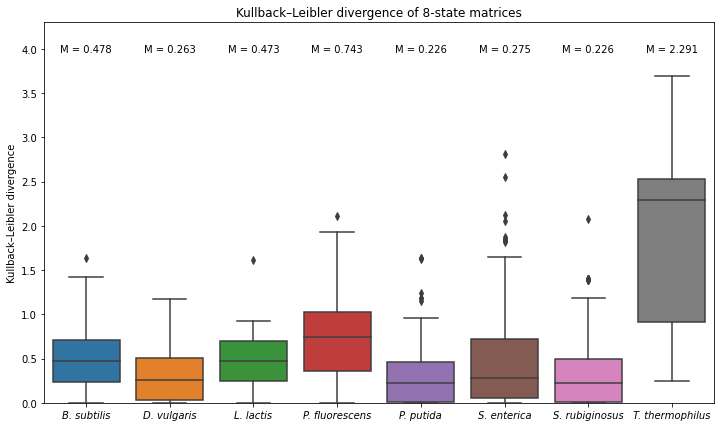

In [ ]:
s_names = []
for s in list(boxes_8.keys()):
  s_names.append(s[0]+'. '+s[1:])

fig1, ax1 = plt.subplots(figsize = (12, 7))
fig1 = sns.boxplot(data = list(boxes_8.values()))
fig1.set_ylabel('Kullback–Leibler divergence')
fig1.set_title('Kullback–Leibler divergence of 8-state matrices')
fig1.set_xticklabels(s_names, style = 'italic')

for cat in fig1.get_xticks():
    y = round(fig1.get_lines()[4+cat*6].get_ydata()[0],3)
    ax1.text(
        cat, 
        4, 
        f'M = {y}', 
        ha='center', 
        va='center', 
        size=10,
        color='black')

plt.ylim([0,4.3])

ax1.get_figure().savefig('08_KLD_split_8.png')
files.download('08_KLD_split_8.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

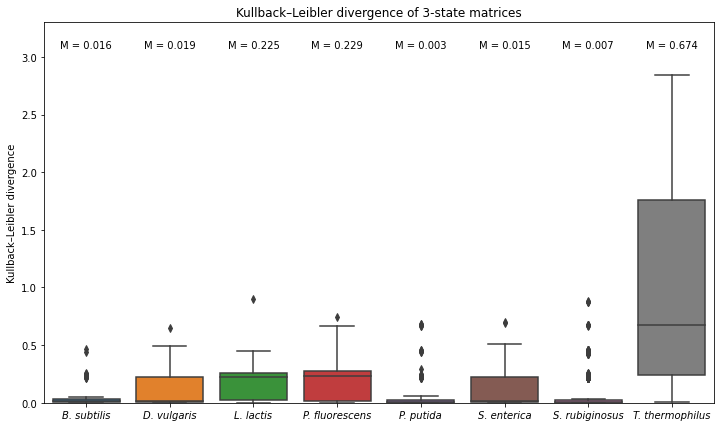

In [ ]:
s_names = []
for s in list(boxes_3.keys()):
  s_names.append(s[0]+'. '+s[1:])

fig1, ax1 = plt.subplots(figsize = (12, 7))
fig1 = sns.boxplot(data = list(boxes_3.values()))
fig1.set_ylabel('Kullback–Leibler divergence')
fig1.set_title('Kullback–Leibler divergence of 3-state matrices')
fig1.set_xticklabels(s_names, style = 'italic')

for cat in fig1.get_xticks():
    y = round(fig1.get_lines()[4+cat*6].get_ydata()[0],3)
    ax1.text(
        cat, 
        3.1, 
        f'M = {y}', 
        ha='center', 
        va='center', 
        size=10,
        color='black')

plt.ylim([0,3.3])

ax1.get_figure().savefig('08_KLD_split_3.png')
files.download('08_KLD_split_3.png')

# Statistical analysis

In [ ]:
b_8 = []

for s in boxes_8.keys():
  b_8.append(boxes_8[s])

b_3 = []

for s in boxes_3.keys():
  b_3.append(boxes_3[s])

In [ ]:
stats.kruskal(boxes_8['Bsubtilis'], boxes_8['Dvulgaris'], boxes_8['Pfluorescens'], boxes_8['Pputida'],
              boxes_8['Senterica'], boxes_8['Srubiginosus'], boxes_8['Tthermophilus'])

KruskalResult(statistic=201.84639939371968, pvalue=7.676604780575967e-41)

In [ ]:
stats.kruskal(boxes_3['Bsubtilis'], boxes_3['Dvulgaris'], boxes_3['Pfluorescens'], boxes_3['Pputida'],
              boxes_3['Senterica'], boxes_3['Srubiginosus'], boxes_3['Tthermophilus'])

KruskalResult(statistic=157.73912269261473, pvalue=1.7831398055060683e-31)

In [ ]:
MWU = pd.DataFrame(abs(np.copy(posthoc_mannwhitney(b_8, p_adjust='bonferroni'))), index=species_names, columns=species_names)
MWU.to_csv('09_MWU_8.csv')
files.download('09_MWU_8.csv')
MWU

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Bsubtilis,Dvulgaris,Llactis,Pfluorescens,Pputida,Senterica,Srubiginosus,Tthermophilus
Bsubtilis,1.000000e+00,0.128230,1.000000,8.346029e-02,7.689125e-08,1.000000e+00,7.022137e-07,6.354373e-05
Dvulgaris,1.282299e-01,1.000000,1.000000,2.271530e-05,2.792180e-04,1.000000e+00,4.222026e-03,2.225874e-06
Llactis,1.000000e+00,1.000000,1.000000,3.255444e-01,1.952741e-02,1.000000e+00,1.049102e-01,1.813778e-03
Pfluorescens,8.346029e-02,0.000023,0.325544,1.000000e+00,1.504816e-09,1.045979e-03,9.219946e-10,1.916253e-02
Pputida,7.689125e-08,0.000279,0.019527,1.504816e-09,1.000000e+00,5.325475e-14,1.000000e+00,5.801825e-08
Senterica,1.000000e+00,1.000000,1.000000,1.045979e-03,5.325475e-14,1.000000e+00,5.215598e-22,4.372646e-06
Srubiginosus,7.022137e-07,0.004222,0.104910,9.219946e-10,1.000000e+00,5.215598e-22,1.000000e+00,5.377432e-08
Tthermophilus,6.354373e-05,0.000002,0.001814,1.916253e-02,5.801825e-08,4.372646e-06,5.377432e-08,1.000000e+00


In [ ]:
MWU = pd.DataFrame(abs(np.copy(posthoc_mannwhitney(b_3, p_adjust='bonferroni'))), index=species_names, columns=species_names)
MWU.to_csv('09_MWU_3.csv')
files.download('09_MWU_3.csv')
MWU

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Bsubtilis,Dvulgaris,Llactis,Pfluorescens,Pputida,Senterica,Srubiginosus,Tthermophilus
Bsubtilis,1.000000,1.000000e+00,0.001347,9.168580e-04,6.643493e-04,1.000000e+00,3.869345e-02,1.059293e-06
Dvulgaris,1.000000,1.000000e+00,0.115577,9.281555e-02,2.818029e-10,3.200821e-01,9.040201e-09,4.799676e-06
Llactis,0.001347,1.155774e-01,1.000000,1.000000e+00,8.106633e-06,6.056631e-03,3.711209e-05,2.607476e-02
Pfluorescens,0.000917,9.281555e-02,1.000000,1.000000e+00,5.638598e-09,1.133899e-04,4.070531e-08,6.667795e-03
Pputida,0.000664,2.818029e-10,0.000008,5.638598e-09,1.000000e+00,2.714220e-10,6.122341e-03,1.850393e-08
Senterica,1.000000,3.200821e-01,0.006057,1.133899e-04,2.714220e-10,1.000000e+00,3.641475e-08,1.945323e-07
Srubiginosus,0.038693,9.040201e-09,0.000037,4.070531e-08,6.122341e-03,3.641475e-08,1.000000e+00,1.909514e-08
Tthermophilus,0.000001,4.799676e-06,0.026075,6.667795e-03,1.850393e-08,1.945323e-07,1.909514e-08,1.000000e+00


In [ ]:
for s in boxes_8.keys():
  print(s, round(np.mean(boxes_8[s]), 3), '±', round(stats.sem(boxes_8[s]) * 1.96, 3), sep=',')

Bsubtilis,0.53,±,0.078
Dvulgaris,0.35,±,0.053
Llactis,0.472,±,0.151
Pfluorescens,0.791,±,0.155
Pputida,0.276,±,0.05
Senterica,0.47,±,0.036
Srubiginosus,0.305,±,0.026
Tthermophilus,1.926,±,0.533


In [ ]:
for s in boxes_3.keys():
  print(s, round(np.mean(boxes_3[s]), 3), '±', round(stats.sem(boxes_3[s]) * 1.96, 3), sep=',')

Bsubtilis,0.065,±,0.022
Dvulgaris,0.112,±,0.027
Llactis,0.217,±,0.088
Pfluorescens,0.218,±,0.061
Pputida,0.064,±,0.02
Senterica,0.094,±,0.011
Srubiginosus,0.072,±,0.011
Tthermophilus,1.019,±,0.441


Function to calculate effect sizes

In [ ]:
def MWU_GlassD(d, alpha = 0.05, p_adjust = 'bonf', sortby='abs_glass', download=False):

  names = []
  values = []

  for s in d.keys():
    for v in d[s]:
      names.append(s[0] + '. ' + s[1:])
      values.append(v)

  distances = pd.DataFrame({'Species':names, 'KL divergence':values})
  s = pairwise_ttests(dv = 'KL divergence', between = 'Species', parametric = False,
                      return_desc = True, alpha = alpha, padjust = p_adjust,
                      effsize = 'glass', data = distances)
  s['abs_glass'] = abs(s['glass'])
  s_filtered = s[s['p-corr'] < 0.05].sort_values(sortby, ascending=False)[['A', 'B', 'glass', 'abs_glass']]
  s_filtered.columns = ['A', 'B', 'Direction', 'Absolute Glass Δ']
  directions = []
  for n in s_filtered['Direction']:
    if n < 0:
      directions.append('<')
    else:
      directions.append('>')
  s_filtered['Direction'] = directions
  
  if download == True:
    s_filtered.to_csv('11_MWU_GlassD.csv')
    files.download('11_MWU_GlassD.csv')
  
  return(s_filtered)

In [ ]:
MWU_GlassD(boxes_8, alpha=0.05, p_adjust='bonf', sortby='abs_glass', download=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,A,B,Direction,Absolute Glass Δ
12,D. vulgaris,T. thermophilus,<,5.428387
24,P. putida,T. thermophilus,<,4.669964
27,S. rubiginosus,T. thermophilus,<,4.524608
17,L. lactis,T. thermophilus,<,3.932944
6,B. subtilis,T. thermophilus,<,3.712595
26,S. enterica,T. thermophilus,<,3.263472
21,P. fluorescens,T. thermophilus,<,2.190517
8,D. vulgaris,P. fluorescens,<,1.519783
18,P. fluorescens,P. putida,>,1.457611
20,P. fluorescens,S. rubiginosus,>,1.357850


In [ ]:
MWU_GlassD(boxes_3, alpha=0.05, p_adjust='bonf', sortby='abs_glass', download=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,A,B,Direction,Absolute Glass Δ
6,B. subtilis,T. thermophilus,<,8.996838
26,S. enterica,T. thermophilus,<,7.006597
24,P. putida,T. thermophilus,<,6.752243
27,S. rubiginosus,T. thermophilus,<,6.493242
12,D. vulgaris,T. thermophilus,<,6.023274
21,P. fluorescens,T. thermophilus,<,3.895201
17,L. lactis,T. thermophilus,<,3.731660
2,B. subtilis,P. fluorescens,<,1.444075
1,B. subtilis,L. lactis,<,1.430295
18,P. fluorescens,P. putida,>,1.089033


# Additional stuff

Counting residues before BLASTp

In [ ]:
uploaded=files.upload()

Saving 02_Bsubtilis_Bsubtilis_AA.FAS to 02_Bsubtilis_Bsubtilis_AA.FAS
Saving 02_Bsubtilis_Ecoli_AA.FAS to 02_Bsubtilis_Ecoli_AA.FAS
Saving 02_Dvulgaris_Dvulgaris_AA.FAS to 02_Dvulgaris_Dvulgaris_AA.FAS
Saving 02_Dvulgaris_Ecoli_AA.FAS to 02_Dvulgaris_Ecoli_AA.FAS
Saving 02_Llactis_Ecoli_AA.FAS to 02_Llactis_Ecoli_AA.FAS
Saving 02_Llactis_Llactis_AA.FAS to 02_Llactis_Llactis_AA.FAS
Saving 02_Pfluorescens_Ecoli_AA.FAS to 02_Pfluorescens_Ecoli_AA.FAS
Saving 02_Pfluorescens_Pfluorescens_AA.FAS to 02_Pfluorescens_Pfluorescens_AA.FAS
Saving 02_Pputida_Ecoli_AA.FAS to 02_Pputida_Ecoli_AA.FAS
Saving 02_Pputida_Pputida_AA.FAS to 02_Pputida_Pputida_AA.FAS
Saving 02_Senterica_Ecoli_AA.FAS to 02_Senterica_Ecoli_AA.FAS
Saving 02_Senterica_Senterica_AA.FAS to 02_Senterica_Senterica_AA.FAS
Saving 02_Srubiginosus_Ecoli_AA.FAS to 02_Srubiginosus_Ecoli_AA.FAS
Saving 02_Srubiginosus_Srubiginosus_AA.FAS to 02_Srubiginosus_Srubiginosus_AA.FAS
Saving 02_Tthermophilus_Ecoli_AA.FAS to 02_Tthermophilus_Ecoli_A

8

In [ ]:
for key in uploaded.keys():
  print(key, 'residues:', uploaded[key].decode('utf-8').count('>'))

02_Bsubtilis_Bsubtilis_AA.FAS residues: 8
02_Bsubtilis_Ecoli_AA.FAS residues: 1145
02_Dvulgaris_Dvulgaris_AA.FAS residues: 26
02_Dvulgaris_Ecoli_AA.FAS residues: 67
02_Llactis_Ecoli_AA.FAS residues: 166
02_Llactis_Llactis_AA.FAS residues: 25
02_Pfluorescens_Ecoli_AA.FAS residues: 275
02_Pfluorescens_Pfluorescens_AA.FAS residues: 13
02_Pputida_Ecoli_AA.FAS residues: 542
02_Pputida_Pputida_AA.FAS residues: 3
02_Senterica_Ecoli_AA.FAS residues: 860
02_Senterica_Senterica_AA.FAS residues: 34
02_Srubiginosus_Ecoli_AA.FAS residues: 11
02_Srubiginosus_Srubiginosus_AA.FAS residues: 17
02_Tthermophilus_Ecoli_AA.FAS residues: 1091
02_Tthermophilus_Tthermophilus_AA.FAS residues: 19


Counting unique residues in each datafile

In [ ]:
uploaded=files.upload()

In [ ]:
for key in uploaded.keys():
  df = pd.read_csv(StringIO(str(uploaded[key],'utf-8')), index_col='Unnamed: 0')
  print(key)
  print('Unique native residues:', len(set([i for j in df['DB_Seq'] for i in j.split('_')])))
  print('Unique EC residues:', len(df['Query'].unique()))

05_Bsubtilis_BLAST_results_filtered.csv
Unique native residues: 4
Unique EC residues: 17
05_Dvulgaris_BLAST_results_filtered.csv
Unique native residues: 4
Unique EC residues: 20
05_Llactis_BLAST_results_filtered.csv
Unique native residues: 5
Unique EC residues: 6
05_Pfluorescens_BLAST_results_filtered.csv
Unique native residues: 4
Unique EC residues: 2
05_Pputida_BLAST_results_filtered.csv
Unique native residues: 1
Unique EC residues: 37
05_Senterica_BLAST_results_filtered.csv
Unique native residues: 29
Unique EC residues: 17
05_Srubiginosus_BLAST_results_filtered.csv
Unique native residues: 17
Unique EC residues: 11
05_Tthermophilus_BLAST_results_filtered.csv
Unique native residues: 7
Unique EC residues: 3
